# Project 3: Munging and analyzing data from the web

In [65]:
from bs4 import BeautifulSoup
import requests
import seaborn as sns
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.simplefilter("ignore", UserWarning)


## Getting data and cleaning

In [66]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36'}

html_best = requests.get('https://www.imdb.com/chart/top/?ref_=nv_mv_250', headers=headers)
html_worst = requests.get('https://m.imdb.com/chart/bottom/', headers=headers)
soup_best = BeautifulSoup(html_best.text, 'html.parser')
soup_worst = BeautifulSoup(html_worst.text, 'html.parser')
display(soup_worst)

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/"><head><meta charset="utf-8"/><meta content="width=device-width" name="viewport"/><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><script>window.addEventListener('load', (event) => {
        if (typeof window.csa !== 'undefined' && typeof window.csa === 'function') {
            var csaLatencyPlugin = window.csa('Content', {
                element: {
                    slotId: 'LoadTitle',
                    type: 'service-call'
                }
            });
            csaLatencyPlugin('mark', 'clickToBodyBegin', 1707884054937);
        }
    })</script><title>Lowest Rated Movies</title><meta content="Bottom 100 as voted by IMDb users" data-id="main" name="description"/><meta content="IMDb" property="og:site_name"/><meta content="Lowest Rated Movies" property="og:title"/><meta content="Bottom 100 as voted by IMDb users"

In [67]:
top_movies = soup_best.find_all('li', attrs={'class': 'ipc-metadata-list-summary-item sc-1364e729-0 caNpAE cli-parent'})

titles_best = [re.sub(r'\d+\.\s*','' ,str(item.find('h3', attrs={'class':'ipc-title__text'}).contents[0])) for item in top_movies]
display(titles_best)

bottom_movies = soup_worst.find_all('li', attrs={'class': 'ipc-metadata-list-summary-item sc-1364e729-0 caNpAE cli-parent'})

titles_worst = [re.sub(r'\d+\.\s*','' ,str(item.find('h3', attrs={'class':'ipc-title__text'}).contents[0])) for item in bottom_movies]
display(titles_worst)

['The Shawshank Redemption',
 'The Godfather',
 'The Dark Knight',
 'The Godfather Part II',
 '12 Angry Men',
 "Schindler's List",
 'The Lord of the Rings: The Return of the King',
 'Pulp Fiction',
 'The Lord of the Rings: The Fellowship of the Ring',
 'The Good, the Bad and the Ugly',
 'Forrest Gump',
 'The Lord of the Rings: The Two Towers',
 'Fight Club',
 'Inception',
 'Star Wars: Episode V - The Empire Strikes Back',
 'The Matrix',
 'Goodfellas',
 "One Flew Over the Cuckoo's Nest",
 'Se7en',
 "It's a Wonderful Life",
 'Interstellar',
 'Seven Samurai',
 'The Silence of the Lambs',
 'Saving Private Ryan',
 'City of God',
 'Life Is Beautiful',
 'The Green Mile',
 'Terminator 2: Judgment Day',
 'Star Wars: Episode IV - A New Hope',
 'Back to the Future',
 'Spirited Away',
 'Spider-Man: Across the Spider-Verse',
 'The Pianist',
 'Parasite',
 'Psycho',
 'Gladiator',
 'The Lion King',
 'Léon: The Professional',
 'The Departed',
 'American History X',
 'Whiplash',
 'The Prestige',
 'Grave

['Disaster Movie',
 'Manos: The Hands of Fate',
 'Birdemic: Shock and Terror',
 'Superbabies: Baby Geniuses 2',
 "Kirk Cameron's Saving Christmas",
 'The Hottie & the Nottie',
 'House of the Dead',
 'Son of the Mask',
 'Epic Movie',
 'Radhe',
 'Pledge This!',
 'Battlefield Earth',
 'Alone in the Dark',
 'Dragonball Evolution',
 'Race 3',
 'Foodfight!',
 'From Justin to Kelly',
 'Going Overboard',
 'Turks in Space',
 'Meet the Spartans',
 'Gigli',
 'Date Movie',
 'Daniel the Wizard',
 'Cats',
 'Baby Geniuses',
 'Glitter',
 'The Human Centipede III (Final Sequence)',
 'Cosmic Sin',
 'Jaws: The Revenge',
 'Troll 2',
 'Mega Shark vs. Giant Octopus',
 'BloodRayne',
 '365 Days: This Day',
 'Jeepers Creepers: Reborn',
 'Hobgoblins',
 'Left Behind',
 'The Cost of Deception',
 '365 Days',
 'Enes Batur: Imagination or Reality?',
 'Winnie-the-Pooh: Blood and Honey',
 'Adipurush',
 "Who's Your Caddy?",
 'Jack and Jill',
 'Rollerball',
 'Santa Claus Conquers the Martians',
 'Slender Man',
 'Catwoma

In [68]:
ratings = soup_best.find_all('div', attrs={'class': 'sc-be6f1408-7 iUtHEN cli-title-metadata'})
rating_items = [item.find_all('span', attrs={'class': 'sc-be6f1408-8 fcCUPU cli-title-metadata-item'}) for item in ratings]
display(rating_items)

ratings_worst = soup_worst.find_all('div', attrs={'class': 'sc-be6f1408-7 iUtHEN cli-title-metadata'})
rating_items_worst = [item.find_all('span', attrs={'class': 'sc-be6f1408-8 fcCUPU cli-title-metadata-item'}) for item in ratings_worst]
display(rating_items_worst)

[[<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1994</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2h 22m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">R</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1972</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2h 55m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">R</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2008</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2h 32m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">PG-13</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1974</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">3h 22m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">R</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1957</span>,
  <span class="sc-be6f1408-8 fcCUP

[[<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2008</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1h 27m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">PG-13</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1966</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1h 10m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">Not Rated</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2010</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1h 45m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">Not Rated</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2004</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">1h 28m</span>,
  <span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">PG</span>],
 [<span class="sc-be6f1408-8 fcCUPU cli-title-metadata-item">2014</span>,
  <span class="sc

In [69]:
pd.set_option('mode.chained_assignment', None)

df = pd.DataFrame()

years_list_best = [] 
length_list_best = []
rating_list_best = []

for i in rating_items:
    years_list_best.append(int(i[0].contents[0]))
    length_list_best.append(i[1].contents[0])
    if len(i) > 2:
        rating_list_best.append(i[2].contents[0])
    else:
        rating_list_best.append('Not Rated')

df['Titles'] = titles_best
df['Years'] = years_list_best
df['Length'] = length_list_best
df['Rating'] = rating_list_best



for i in range(len(df['Length'])):
    if 'm' not in df['Length'][i]:
        s = pd.to_datetime(df.Length[i],format='%Hh')
        df.replace({'Length': df['Length'][i]}, s.hour*60)
        df['Length'][i] = float(s.hour*60)
    elif 'h' not in df['Length'][i]:
        s = pd.to_datetime(df.Length[i],format='%Mm')
        df.replace({'Length': df['Length'][i]}, s.minute)
        df['Length'][i] = float(s.minute)
    else:
        s = pd.to_datetime(df.Length[i], format='%Hh %Mm')
        df.replace({'Length': df['Length'][i]}, s.hour*60+s.minute)
        df['Length'][i] = float(s.hour*60+s.minute)


df['Length'] = df.Length.astype(float)
df

,Titles,Years,Length,Rating
0,The Shawshank Redemption,1994,142.0,R
1,The Godfather,1972,175.0,R
2,The Dark Knight,2008,152.0,PG-13
3,The Godfather Part II,1974,202.0,R
4,12 Angry Men,1957,96.0,Approved
...,...,...,...,...
245,The Help,2011,146.0,PG-13
246,It Happened One Night,1934,105.0,Passed
247,The 400 Blows,1959,99.0,Not Rated
248,Gangs of Wasseypur,2012,321.0,Not Rated


In [70]:
df_worst = pd.DataFrame()

years_list_worst = [] 
length_list_worst = []
rating_list_worst = []

for i in rating_items_worst:
    years_list_worst.append(int(i[0].contents[0]))
    length_list_worst.append(i[1].contents[0])
    if len(i) > 2:
        rating_list_worst.append(i[2].contents[0])
    else:
        rating_list_worst.append('Not Rated')

df_worst['Titles'] = titles_worst
df_worst['Years'] = years_list_worst
df_worst['Length'] = length_list_worst
df_worst['Rating'] = rating_list_worst



for i in range(len(df_worst['Length'])):
    if 'm' not in df_worst['Length'][i]:
        s = pd.to_datetime(df_worst.Length[i],format='%Hh')
        df_worst.replace({'Length': df_worst['Length'][i]}, s.hour*60)
        df_worst['Length'][i] = float(s.hour*60)
        
    elif 'h' not in df_worst['Length'][i]:
        s = pd.to_datetime(df_worst.Length[i],format='%Mm')
        df_worst.replace({'Length': df_worst['Length'][i]}, s.minute)
        df_worst['Length'][i] = float(s.minute)
    else:
        s = pd.to_datetime(df_worst.Length[i], format='%Hh %Mm')
        df_worst.replace({'Length': df_worst['Length'][i]}, s.hour*60+s.minute)
        df_worst['Length'][i] = float(s.hour*60+s.minute)



df_worst['Length'] = df_worst.Length.astype(float)
df_worst

,Titles,Years,Length,Rating
0,Disaster Movie,2008,87.0,PG-13
1,Manos: The Hands of Fate,1966,70.0,Not Rated
2,Birdemic: Shock and Terror,2010,105.0,Not Rated
3,Superbabies: Baby Geniuses 2,2004,88.0,PG
4,Kirk Cameron's Saving Christmas,2014,79.0,PG
...,...,...,...,...
95,The Hungover Games,2014,85.0,R
96,The Love Guru,2008,87.0,PG-13
97,In the Name of the King: A Dungeon Siege Tale,2007,127.0,PG-13
98,The Avengers,1998,89.0,PG-13


In [71]:
user_rating_best = soup_best.find_all('span', attrs={'class':'ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating'})
user_rating_comb_best = [item.get_text(strip=True ) for item in user_rating_best]
user_rating_best = [float(re.sub(r'\(.+\)', '', item)) for item in user_rating_comb_best]
# display(user_rating_best)

df['ReviewRating'] = user_rating_best
display(df)

user_rating_worst = soup_worst.find_all('span', attrs={'class':'ipc-rating-star ipc-rating-star--base ipc-rating-star--imdb ratingGroup--imdb-rating'})
user_rating_comb_worst = [item.get_text(strip=True ) for item in user_rating_worst]
user_rating_worst = [float(re.sub(r'\(.+\)', '', item)) for item in user_rating_comb_worst]
# display(user_rating_worst)

df_worst['ReviewRating'] = user_rating_worst
display(df_worst)

,Titles,Years,Length,Rating,ReviewRating
0,The Shawshank Redemption,1994,142.0,R,9.3
1,The Godfather,1972,175.0,R,9.2
2,The Dark Knight,2008,152.0,PG-13,9.0
3,The Godfather Part II,1974,202.0,R,9.0
4,12 Angry Men,1957,96.0,Approved,9.0
...,...,...,...,...,...
245,The Help,2011,146.0,PG-13,8.1
246,It Happened One Night,1934,105.0,Passed,8.1
247,The 400 Blows,1959,99.0,Not Rated,8.1
248,Gangs of Wasseypur,2012,321.0,Not Rated,8.2


,Titles,Years,Length,Rating,ReviewRating
0,Disaster Movie,2008,87.0,PG-13,1.9
1,Manos: The Hands of Fate,1966,70.0,Not Rated,1.6
2,Birdemic: Shock and Terror,2010,105.0,Not Rated,1.7
3,Superbabies: Baby Geniuses 2,2004,88.0,PG,1.5
4,Kirk Cameron's Saving Christmas,2014,79.0,PG,1.3
...,...,...,...,...,...
95,The Hungover Games,2014,85.0,R,3.5
96,The Love Guru,2008,87.0,PG-13,3.8
97,In the Name of the King: A Dungeon Siege Tale,2007,127.0,PG-13,3.8
98,The Avengers,1998,89.0,PG-13,3.8


In [72]:
rating_count_best = [re.search(r'\(\d+(\.\d)?\w', item).group() for item in user_rating_comb_best]
rating_count_best = [re.sub(r'\(', '', item) for item in rating_count_best]

rating_count_worst = [re.search(r'\(\d+(\.\d)?\w', item).group() for item in user_rating_comb_worst]
rating_count_worst = [re.sub(r'\(', '', item) for item in rating_count_worst]

for i in range(len(rating_count_best)):

    if rating_count_best[i][-1] == 'M':

        rating_count_best[i] = float(rating_count_best[i][:-1])*1000000
    elif rating_count_best[i][-1] == "K":

        rating_count_best[i] = float(rating_count_best[i][:-1])*1000
# display(rating_count_best)

for i in range(len(rating_count_worst)):

    if rating_count_worst[i][-1] == 'M':

        rating_count_worst[i] = float(rating_count_worst[i][:-1])*1000000
    elif rating_count_worst[i][-1] == "K":

        rating_count_worst[i] = float(rating_count_worst[i][:-1])*1000
# display(rating_count_worst)


df['numReviews'] = rating_count_best
df_worst['numReviews'] = rating_count_worst
display(df)
display(df_worst)

,Titles,Years,Length,Rating,ReviewRating,numReviews
0,The Shawshank Redemption,1994,142.0,R,9.3,2900000.0
1,The Godfather,1972,175.0,R,9.2,2000000.0
2,The Dark Knight,2008,152.0,PG-13,9.0,2800000.0
3,The Godfather Part II,1974,202.0,R,9.0,1400000.0
4,12 Angry Men,1957,96.0,Approved,9.0,854000.0
...,...,...,...,...,...,...
245,The Help,2011,146.0,PG-13,8.1,488000.0
246,It Happened One Night,1934,105.0,Passed,8.1,111000.0
247,The 400 Blows,1959,99.0,Not Rated,8.1,127000.0
248,Gangs of Wasseypur,2012,321.0,Not Rated,8.2,103000.0


,Titles,Years,Length,Rating,ReviewRating,numReviews
0,Disaster Movie,2008,87.0,PG-13,1.9,94000.0
1,Manos: The Hands of Fate,1966,70.0,Not Rated,1.6,37000.0
2,Birdemic: Shock and Terror,2010,105.0,Not Rated,1.7,25000.0
3,Superbabies: Baby Geniuses 2,2004,88.0,PG,1.5,32000.0
4,Kirk Cameron's Saving Christmas,2014,79.0,PG,1.3,17000.0
...,...,...,...,...,...,...
95,The Hungover Games,2014,85.0,R,3.5,17000.0
96,The Love Guru,2008,87.0,PG-13,3.8,55000.0
97,In the Name of the King: A Dungeon Siege Tale,2007,127.0,PG-13,3.8,51000.0
98,The Avengers,1998,89.0,PG-13,3.8,45000.0


## Number of ratings vs length

Text(0.5, 1.0, 'Top 250 Movie Length vs. Review Rating')

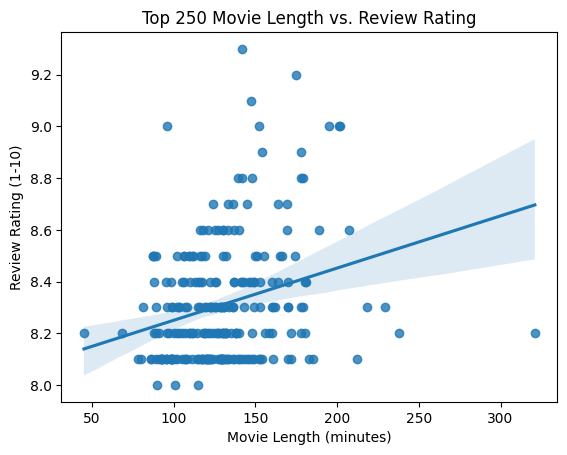

In [73]:
p_best = sns.regplot(x = 'Length', y = 'ReviewRating', data=df)

p_best.set_xlabel('Movie Length (minutes)')
p_best.set_ylabel('Review Rating (1-10)')
p_best.set_title('Top 250 Movie Length vs. Review Rating')

Text(0.5, 1.0, '100 Lowest Rated Movie Length vs. Review Rating')

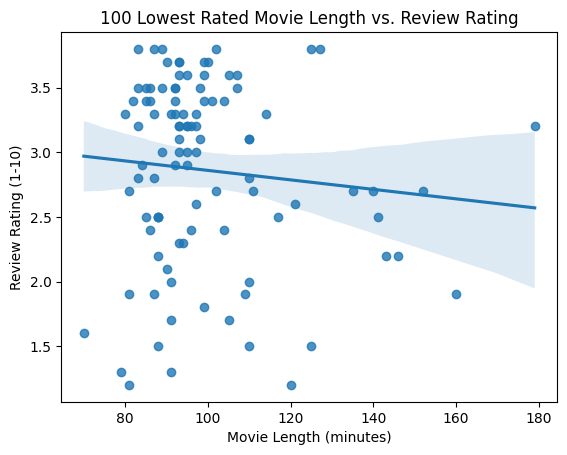

In [74]:
p_worst = sns.regplot(x = 'Length', y = 'ReviewRating', data=df_worst)

p_worst.set_xlabel('Movie Length (minutes)')
p_worst.set_ylabel('Review Rating (1-10)')
p_worst.set_title('100 Lowest Rated Movie Length vs. Review Rating')

In [75]:
print("Best:", stats.pearsonr(df.Length, df.ReviewRating))
print("Worst:", stats.pearsonr(df_worst.Length, df_worst.ReviewRating))

Best: PearsonRResult(statistic=0.2745107599542785, pvalue=1.0650271940505026e-05)
Worst: PearsonRResult(statistic=-0.09591258008191175, pvalue=0.3424894412949775)


## Average movie length and review rating for top 250 vs bottom 100

In [76]:
print("Best")
best_average_rating = sum(df['ReviewRating']) / len(df['ReviewRating'])
display(best_average_rating)


best_average_length = sum(df['Length']) / len(df['Length'])
display(best_average_length)

print("Worst")
worst_average_rating = sum(df_worst['ReviewRating']) / len(df_worst['ReviewRating'])
display(worst_average_rating)

worst_average_length = sum(df_worst['Length']) / len(df_worst['Length'])
display(worst_average_length)

Best


8.311199999999971

130.184

Worst


2.8609999999999998

99.73

## Mean movie length and review rating for top 250 vs bottom 100

In [77]:
print("Best")

display(df['ReviewRating'].mean())
display(df['Length'].mean())


print("Worst")

display(df_worst['ReviewRating'].mean())
display(df_worst['Length'].mean())

Best


8.311200000000001

130.184

Worst


2.861

99.73

In [78]:
display(stats.ttest_ind(df.Length, df_worst.Length))

Ttest_indResult(statistic=8.904737164022695, pvalue=3.016897769962164e-17)

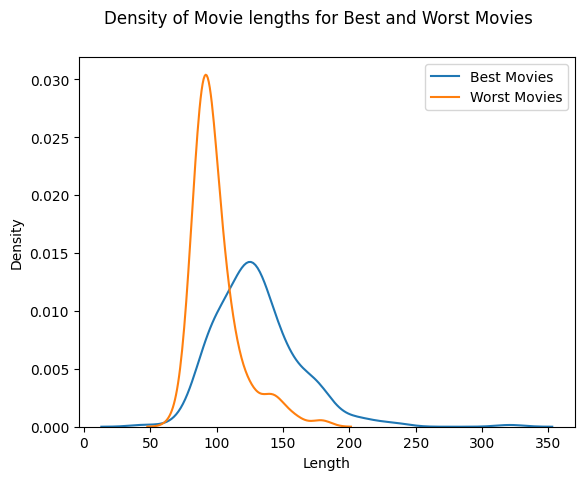

In [79]:
fig, ax = plt.subplots()
sns.kdeplot(df['Length'],label='Best Movies')
sns.kdeplot(df_worst['Length'], label='Worst Movies')
fig.suptitle('Density of Movie lengths for Best and Worst Movies')
plt.legend()

# Number of reviews vs. Average rating

all movies:  PearsonRResult(statistic=0.5762192395461168, pvalue=1.622690027807698e-23)


<Figure size 640x480 with 0 Axes>

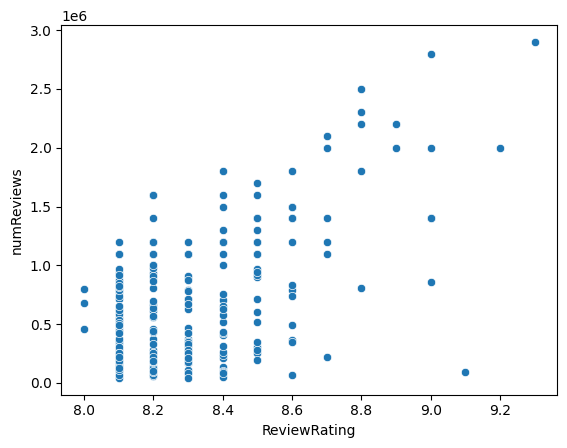

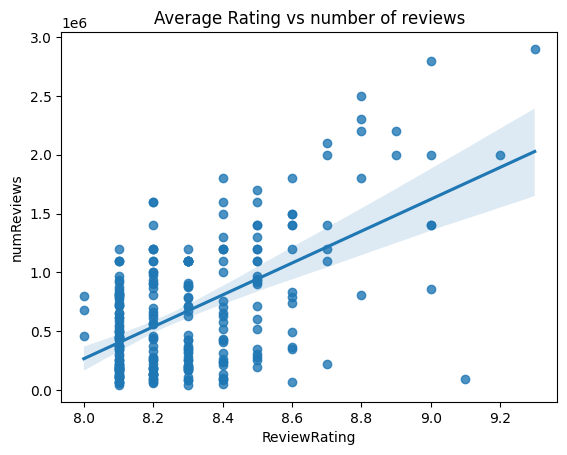

<Figure size 640x480 with 0 Axes>

In [80]:
sns.scatterplot(data=df, x='ReviewRating', y='numReviews')
plt.figure()
sns.regplot(data=df, x='ReviewRating', y='numReviews')
print('all movies: ', stats.pearsonr(x=df['ReviewRating'], y=df['numReviews']))
plt.title('Average Rating vs number of reviews')
plt.figure()

# Does MPAA rating affect the reviews? 

['R' 'PG-13' 'Approved' 'PG' 'Not Rated' 'G' 'Passed' 'TV-PG' 'Unrated'
 '18+' 'X' 'TV-MA' 'GP']
Index(['R', 'PG', 'PG-13', 'Not Rated', 'G', 'Passed', 'Approved', 'TV-PG',
       'Unrated', '18+', 'X', 'TV-MA', 'GP'],
      dtype='object', name='Rating')


Ttest_indResult(statistic=1.6495964924859403, pvalue=0.10102484056291572)

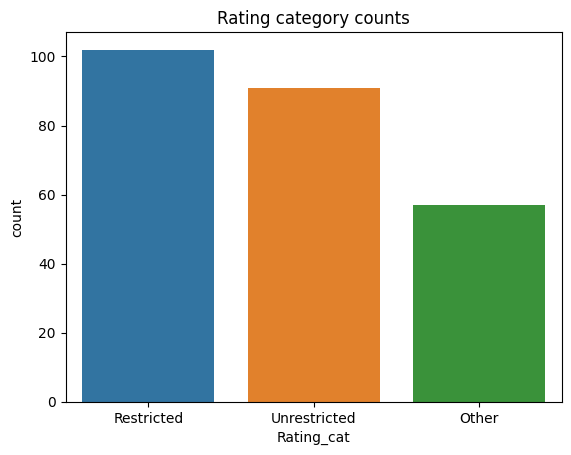

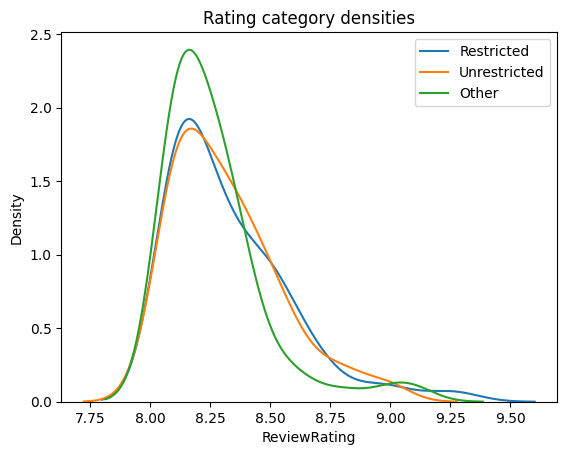

In [81]:
# Films that are not rated were not made in the US
print(df['Rating'].unique())
print(df['Rating'].value_counts().keys())

mapping = {'R':'Restricted', 'X':'Restricted', '18+': 'Restricted', 'TV-MA':'Restricted', 'G':'Unrestricted', 
           'PG':'Unrestricted', 'TV-PG':'Unrestricted', 'PG-13':'Unrestricted', 'Unrated':'Other', 
           'Passed':'Other', 'Approved':'Other', 'GP':'Other', 'Not Rated':'Other'}
df['Rating_cat'] = df['Rating'].replace(mapping)


sns.countplot(data=df, x='Rating_cat', hue='Rating_cat')
plt.title('Rating category counts')
plt.figure()
sns.kdeplot(data=df[df['Rating_cat'] == 'Restricted'], x='ReviewRating', label='Restricted')
sns.kdeplot(data=df[df['Rating_cat'] == 'Unrestricted'], x='ReviewRating', label = 'Unrestricted')
sns.kdeplot(data=df[df['Rating_cat'] == 'Other'], x='ReviewRating', label='Other')
plt.legend()
plt.title('Rating category densities')
age_restricted = df[df['Rating_cat'] == 'Restricted']['ReviewRating']
not_age_restricted = df[df['Rating_cat'] == 'Unrestricted']['ReviewRating']
not_age_restricted = df[df['Rating_cat'] == 'Other']['ReviewRating']
stats.ttest_ind(age_restricted, not_age_restricted, nan_policy='omit')